# データの読み込み（pygrib）
参考文献  
[Jupyter nbviewer - Matplotlib/Basemap and pygrib example](https://nbviewer.jupyter.org/gist/jswhit/8635665)  
[MetPy Mondays - #135 Reading GRIB files](https://youtu.be/yLoudFv3hAY)  
[Qiita - grib2をpython(matplotlib)で地図上で可視化](https://qiita.com/mhangyo/items/f06debce3975a269a658)  
[Qiita - 気象データをもとに「天気図っぽい前線」を機械学習で描いてみる(2)](https://qiita.com/m-taque/items/988b08185097dca5f5b5)

In [1]:
import pygrib
import numpy as np

In [2]:
grbs = pygrib.open('d/anl_p125_hgt.195801')
#grbs = pygrib.open('d/anl_surf125.195801')

In [3]:
#grbs.rewind()

In [4]:
vals, levs = [], []

for grb in grbs:
    #print(grb)  # gribメッセージの出力（多分wgribと同じ）
    #print(grb.parameterName, '|', grb.level)
    vals.append(grb.values)  # データの読み込み
    levs.append(grb.level)  # 気圧面情報の読み込み

In [5]:
lats_m, lons_m = grb.latlons()  # np.meshgridと同じ状態の二次元配列
lats = lats_m[:, 0]  # meshgridを解体して
lons = lons_m[0, :]  # 一次元の数列にする

In [6]:
vals = np.array(vals)
vals.shape

(37, 145, 288)

# データの整理（XarrayによるnetCDF的な利用）
[Wikipedia - NetCDF](https://ja.wikipedia.org/wiki/NetCDF)  
[Qiita - xarrayを用いたデータ解析](https://qiita.com/fujiisoup/items/0d71995e54055e9708fc)  
[xarray User Guide - Data Structures](https://xarray.pydata.org/en/stable/user-guide/data-structures.html)  
[xarray User Guide - Reading and writing files](http://xarray.pydata.org/en/stable/user-guide/io.html#)  
[stack overflow - How to undo or reverse np.meshgrid?](https://stackoverflow.com/questions/53385605/how-to-undo-or-reverse-np-meshgrid)  

In [7]:
import xarray as xr
import pandas as pd

In [8]:
times = pd.date_range('1958-01-01 00', periods=1, freq='6H')
times

DatetimeIndex(['1958-01-01'], dtype='datetime64[ns]', freq='6H')

In [9]:
print(len(times))
print(len(levs))
print(len(lats))
print(len(lons))

1
37
145
288


In [10]:
da = xr.DataArray(
    np.array(vals, dtype='f4'), dims=['lev', 'lat', 'lon'],
    coords={'lev': levs,
            'lat': lats,
            'lon': lons,},
    name='GeopotentialHeight',
    attrs={'time': str(times[0]),
           'units': 'gpm',
           'dataset': 'JRA-55'})

In [11]:
da.to_netcdf('d/test3.nc')  # COARDS規約に則ってないのでGrADSで書くにはctlファイルが必要

# 簡易的な作図（Xarray & Cartopy）
[Qiita - xarrayを用いたデータ解析](https://qiita.com/fujiisoup/items/0d71995e54055e9708fc)  
[xarray User Guide - Plotting - Maps](https://xarray.pydata.org/en/stable/user-guide/plotting.html#maps)

In [12]:
import cartopy.crs as ccrs

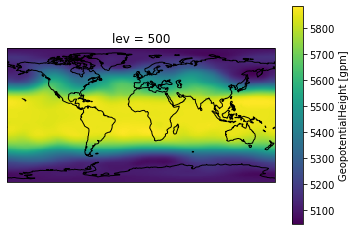

In [13]:
z = da.sel(lev=500)
fig = z.plot(subplot_kws=dict(projection=ccrs.PlateCarree()))
fig.axes.coastlines()